In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import numpy as np
from scipy import stats
import importlib
import src.assay_calibration.fit_utils.two_sample.fit
from src.assay_calibration.fit_utils.fit import Fit
importlib.reload(src.assay_calibration.fit_utils.two_sample.fit)
importlib.reload(src.assay_calibration.fit_utils.fit)
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib
matplotlib.set_loglevel("warning")
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
import os
sys.path.append(str(Path(os.getcwd()).parent))
from src.assay_calibration.data_utils.dataset import (
    PillarProjectDataframe,
    Scoreset,
    BasicScoreset,
)
import json
import glob

In [2]:
# from src.assay_calibration.data_utils.dataset import (
#     PillarProjectDataframe,
#     Scoreset,
#     BasicScoreset,
# )
# ds = Scoreset.from_json("/data/ross/assay_calibration/scoresets/CALM1_CALM2_CALM3_Weile_2017.json")

In [3]:
# dir(ds)

In [4]:
# ds.scoreset_name

In [5]:
# for sample in ds.samples:
#     print(sample[1])
#     # break

In [6]:
def test_fit(ds, component_range, check_monotonic, init_strategy, bootstrap_seed=None):
    # Load directly from JSON
    fit = Fit(ds)
    fits, best_idx, best_val_ll = fit.run(
                core_limit=10,
                num_fits=100,
                verbose_level=20,
                component_range=component_range,
                bootstrap=True,
                bootstrap_seed=bootstrap_seed,
                verbose=False,
                max_em_iters=10000,
                check_convergence=False,
                check_monotonic=check_monotonic,
                # submerge_steps=None,#256 if check_monotonic else None,
                init_strategy=init_strategy,
                score_min=ds.scores.min() - 1,
                score_max=ds.scores.max() + 1,
                # init_constraint_adjustment_param="skew",
                # kmean_init="k-means++"
            )
    
    return fits, ds, best_idx, best_val_ll

# for dataset_f in glob.glob("/data/ross/assay_calibration/scoresets/*.json"):
    
#     dataset_name = dataset_f.split('/')[-1][:-5]

#     for component_range in ("2-component","3-component"):
#         for monotonicity_contraint in ("no constraint","constraint"):
#             # for init_strategy in ("kmeans","random"):
#             init_strategy = "kmeans"
            
#             fits, ds = test_fit(dataset_f, component_range=[3] if component_range[0] == "3" else [2], 
#                                 check_monotonic=False if monotonicity_contraint[0] == "n" else True, 
#                                 init_strategy=init_strategy)
            
#             fit_results = sorted(fits, key=lambda res: res['likelihoods'][-1], reverse=True)
#             best_fit = fit_results[0]
#             scores = ds.scores
#             sample_assignments = ds.sample_assignments
            
#             score_range = np.linspace(scores.min(), scores.max(), 1000)
#             estimatedDensities = np.array([density_utils.joint_densities(score_range[...,None],
#                                                                          best_fit['component_params'],
#                                                                          sample_weights).squeeze() for sample_weights in best_fit['weights']])
            
#             fig,ax = plt.subplots(3,1, figsize=(12,12))
#             for i in range(3):
#                 ax[i].plot(score_range, estimatedDensities[i].sum(0), label='Estimated', color='C1', linestyle='--')
#                 ax[i].hist(scores[sample_assignments[:,i]], density=True, alpha=0.3, color='gray', label='Data histogram')
#                 ax[i].set_title(f'Sample {i+1}')
#                 ax[i].legend()

In [7]:
all_results = {}

In [8]:
#### import matplotlib.pyplot as plt
import glob
import os
import numpy as np

N_BOOTSTRAPS = 100

# Create output directory if it doesn't exist
output_dir = "/data/ross/assay_calibration/test_experimental_plots_v9"
os.makedirs(output_dir, exist_ok=True)

# Suppress matplotlib debug messages
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

n_non_violating_fits_without_constraint = 0

for dataset_f in (
    glob.glob("/data/ross/assay_calibration/scoresets/BRCA1*Findlay*.json")
):
    
    dataset_name = dataset_f.split('/')[-1][:-5]
    print(f"Processing {dataset_name}")

    ds = Scoreset.from_json(dataset_f)
    print(ds)

    sample_names = np.array([sample[1] for sample in ds.samples])
    
    # Create figure with 4x3 subplot grid
    # fig, axes = plt.subplots(len(sample_names), 4, figsize=(18, 5*len(sample_names)))
    # fig.suptitle(f'Dataset: {dataset_name}', fontsize=16, y=0.995)

    all_results[dataset_name] = {}
    
    # plot_idx = 0
    for component_range in ["2-component", "3-component"]:
        for monotonicity_constraint in ["constraint"]:#["constraint", "no constraint"]:
            # for init_density_fix in ["lambda","sigma"]:
            init_strategy = "random"


            all_results[dataset_name][(component_range, monotonicity_constraint)] = []
    
            for bootstrap_iter in range(N_BOOTSTRAPS):
                print(f'bootstrap {bootstrap_iter} start...',end='')
                
                try:
                
                    # Run the fit
                    fits, ds, best_idx, best_val_ll = test_fit(
                        ds, 
                        component_range=[3] if component_range[0] == "3" else [2], 
                        check_monotonic=False if monotonicity_constraint[0] == "n" else True, 
                        init_strategy=init_strategy,
                        bootstrap_seed=bootstrap_iter
                    )

                    save_dict = {'fit': fits[best_idx], 
                                 'best_val_ll': best_val_ll}
                    all_results[dataset_name][(component_range, monotonicity_constraint)].append(save_dict)
                    print(f' val_ll: {best_val_ll}')
                    
                    # Get best fit
                    # fit_results = sorted(fits, key=lambda res: res['likelihoods'][-1], reverse=True)
                    # times_submerged = [results['times_submerged'] for results in fit_results if len(results['times_submerged']) != 0]
                    # print(dataset_name, component_range, monotonicity_constraint, times_submerged)
                    # best_fit = fit_results[0]
                    # best_init = "MoM" if best_fit['kmeans'] == "method_of_moments" else "KM"
                    # xlims = best_fit['xlims']
                    # scores = ds.scores
                    # sample_assignments = ds.sample_assignments
        
                    
                    # all_results[dataset_name][(component_range, monotonicity_constraint)].append({'fit': best_fit, 
                    #                                                                          'times_submerged': times_submerged}) 
        
                    # # Calculate densities
                    # score_range = np.linspace(scores.min(), scores.max(), 1000)
                    # estimatedDensities = np.array([
                    #     density_utils.joint_densities(
                    #         score_range[..., None],
                    #         best_fit['component_params'],
                    #         sample_weights
                    #     ).squeeze() for sample_weights in best_fit['weights']
                    # ])
                    
                    # # Check if density constraint violated
                    # fit_violates_constraint = constraints.multicomponent_density_constraint_violated(best_fit['component_params'], xlims)
                    # if monotonicity_constraint == "no constraint" and fit_violates_constraint:
                    #     n_non_violating_fits_without_constraint += 1
                    # fit_violates_constraint = "violates" if fit_violates_constraint else "not violates"
                    
                    # # Plot for each sample (3 columns)
                    # for i in range(len(estimatedDensities)):
                    #     ax = axes[i, plot_idx]
                        
                    #     # Plot estimated density
                    #     ax.plot(score_range, estimatedDensities[i].sum(0), 
                    #            label='Estimated', color='C1', linestyle='-', linewidth=2)
                        
                    #     # Plot histogram of actual data
                    #     if i < sample_assignments.shape[1] and sample_assignments[:, i].sum() > 0:
                    #         ax.hist(scores[sample_assignments[:, i]], 
                    #                bins=30, density=True, alpha=0.3, 
                    #                color='gray', label='Data')
                        
                    #     # Set labels and title
                    #     if plot_idx == 0:
                    #         ax.set_ylabel(sample_names[i], 
                    #                      fontsize=12, fontweight='bold')
                        
                    #     if i == 0:
                    #         ax.set_title(f'{component_range}, {monotonicity_constraint}, {best_init}, {fit_violates_constraint}', fontsize=12)
                        
                    #     if i == len(estimatedDensities) - 1:
                    #         ax.set_xlabel('Score', fontsize=10)
                        
                    #     ax.legend(loc='upper right', fontsize=8)
                    #     ax.grid(True, alpha=0.2)
                        
                    #     # Add likelihood value as text
                    #     likelihood = best_fit['likelihoods'][-1]
                    #     ax.text(0.02, 0.98, f'LL: {likelihood:.3f}, n={len(scores[sample_assignments[:, i]])}', 
                    #            transform=ax.transAxes, fontsize=12,
                    #            verticalalignment='top')
                    
                except Exception as e:
                    print(f"  Error with {component_range}, {monotonicity_constraint} bootstrap {bootstrap_iter}: {e}")
                    # Create empty plots with error message
                    # for i in range(len(estimatedDensities)):
                    #     ax = axes[i, plot_idx]
                    #     ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', 
                    #            ha='center', va='center', transform=ax.transAxes)
                    #     ax.set_xticks([])
                    #     ax.set_yticks([])
    
                    #     if i == 0:
                    #         ax.set_title(f'{component_range}, {monotonicity_constraint}, {best_init}, {fit_violates_constraint}', fontsize=12)
                        
                    #     if plot_idx == 0:
                    #         ax.set_ylabel(sample_names[i], 
                    #                      fontsize=12, fontweight='bold')
                        
                    #     if i == len(estimatedDensities) - 1:
                    #         ax.set_xlabel('Score', fontsize=10)
            
            # plot_idx += 1
    
    # Adjust layout and save
    # plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # output_path = f"{output_dir}/{dataset_name}.png"
    # plt.savefig(output_path, dpi=100, bbox_inches='tight')
    # plt.close()
    
    # print(f"  Saved to {output_path}")

# print("All plots saved!")

Processing BRCA1_Findlay_2018
BRCA1_Findlay_2018: 3893 total variants
	Pathogenic/Likely Pathogenic: 410 variants
	Benign/Likely Benign: 270 variants
	gnomAD: 599 variants
	Synonymous: 544 variants

bootstrap 0 start... val_ll: -0.6745456990819685
bootstrap 1 start... val_ll: -0.7084326673416691
bootstrap 2 start... val_ll: -0.6363487064624225
bootstrap 3 start... val_ll: -0.73400375167843
bootstrap 4 start... val_ll: -0.6312858970605261
bootstrap 5 start... val_ll: -0.6578910985750748
bootstrap 6 start... val_ll: -0.658764516275088
bootstrap 7 start... val_ll: -0.6110716196218919
bootstrap 8 start... val_ll: -0.6407586564904852
bootstrap 9 start... val_ll: -0.6103156590841283
bootstrap 10 start... val_ll: -0.5868236543984076
bootstrap 11 start...Iteration 14: Likelihood (-0.6237200335968393->-0.6237200335968394) decreased by 1.11e-16 (relative: 1.78e-16) - (numerical rounding?). Params: [(-0.09596126523705126, -2.0156759239008504, 0.579481698954351), (-0.04451294760983482, -0.04151610

/home/rcstewart/assay_calibration/src/assay_calibration/fit_utils/two_sample/density_utils.py:110: RuntimeWarning: divide by zero encountered in log
  Likelihood += np.log(sample_likelihood).sum().item()


 val_ll: -0.6018668663498786
bootstrap 18 start... val_ll: -0.6337977033169611
bootstrap 19 start... val_ll: -0.6425992514903117
bootstrap 20 start... val_ll: -0.6564426668484828
bootstrap 21 start... val_ll: -0.6974619798453954
bootstrap 22 start... val_ll: -0.7341756383277215
bootstrap 23 start... val_ll: -0.6475449412118442
bootstrap 24 start... val_ll: -0.6107924152060381
bootstrap 25 start... val_ll: -0.6467725317718171
bootstrap 26 start... val_ll: -0.6155243126379898
bootstrap 27 start... val_ll: -0.630490382078949
bootstrap 28 start... val_ll: -0.6557456925389196
bootstrap 29 start... val_ll: -0.5667600386429619
bootstrap 30 start... val_ll: -0.549156090542572
bootstrap 31 start... val_ll: -0.6025187744592441
bootstrap 32 start... val_ll: -0.6062048672394811
bootstrap 33 start... val_ll: -0.6210316541231208
bootstrap 34 start... val_ll: -0.656033836259756
bootstrap 35 start... val_ll: -0.6779312984830956
bootstrap 36 start... val_ll: -0.6021121473812894
bootstrap 37 start... va

In [20]:
from collections import defaultdict
val_lls = defaultdict(list) # 100 same bootstraps
weights = defaultdict(list)
for dataset in all_results:
    for key in all_results[dataset]:
        for i,bootstrap_results in enumerate(all_results[dataset][key]):
            if i == 14 and key[0] == '2-component': # erroneous 3-component example, skip for 2 as well
                continue
            val_lls[key[0]].append(bootstrap_results['best_val_ll'])
            weights[key[0]].append(bootstrap_results['fit']['weights'])


In [45]:
with open('/data/ross/assay_calibration/bootstrap/BRCA1_Findlay_2018/2vs3_bootstrap_val_lls.txt','w') as f:
    for key in val_lls:
        f.write('>'+key+'\n')
        for ll in val_lls[key]:
            f.write(str(ll)+'\n')
    

In [13]:
weights

defaultdict(list,
            {'2-component': [array([[9.96151402e-01, 3.84859767e-03],
                     [9.20687100e-13, 1.00000000e+00],
                     [2.27823971e-01, 7.72176029e-01],
                     [7.48372902e-03, 9.92516271e-01]]),
              array([[9.92030147e-001, 7.96985346e-003],
                     [1.13106866e-194, 1.00000000e+000],
                     [2.13177468e-001, 7.86822532e-001],
                     [1.30737910e-002, 9.86926209e-001]]),
              array([[0.9911684 , 0.0088316 ],
                     [0.        , 1.        ],
                     [0.1953632 , 0.8046368 ],
                     [0.00925922, 0.99074078]]),
              array([[0.99727316, 0.00272684],
                     [0.00496195, 0.99503805],
                     [0.16733757, 0.83266243],
                     [0.00754382, 0.99245618]]),
              array([[0.99466505, 0.00533495],
                     [0.00471793, 0.99528207],
                     [0.18436818, 0.81563

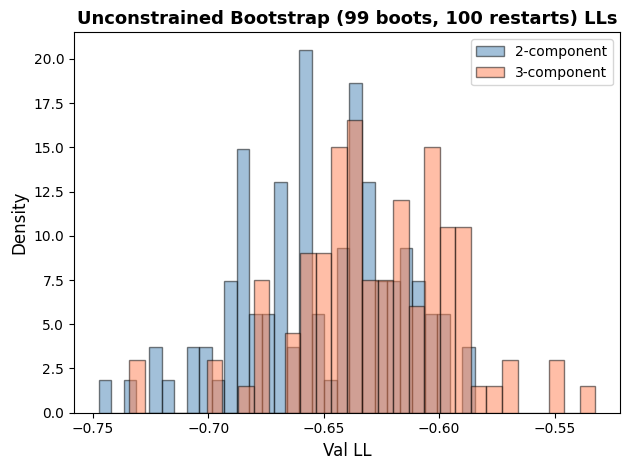

In [24]:
import matplotlib.pyplot as plt
import numpy as np


data_2comp = np.array(val_lls['2-component'])
data_3comp = np.array(val_lls['3-component'])

plt.hist(data_2comp, bins=30,
             edgecolor='black', alpha=0.5, color='steelblue', density=True, label='2-component')
plt.hist(data_3comp, bins=30,
             edgecolor='black', alpha=0.5, color='coral', density=True, label='3-component')

plt.xlabel('Val LL', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Unconstrained Bootstrap ({len(data_2comp)} boots, 100 restarts) LLs', fontsize=13, fontweight='bold')

plt.legend()


plt.tight_layout()
plt.show()

In [25]:
len(data_2comp), len(data_3comp)

(99, 99)

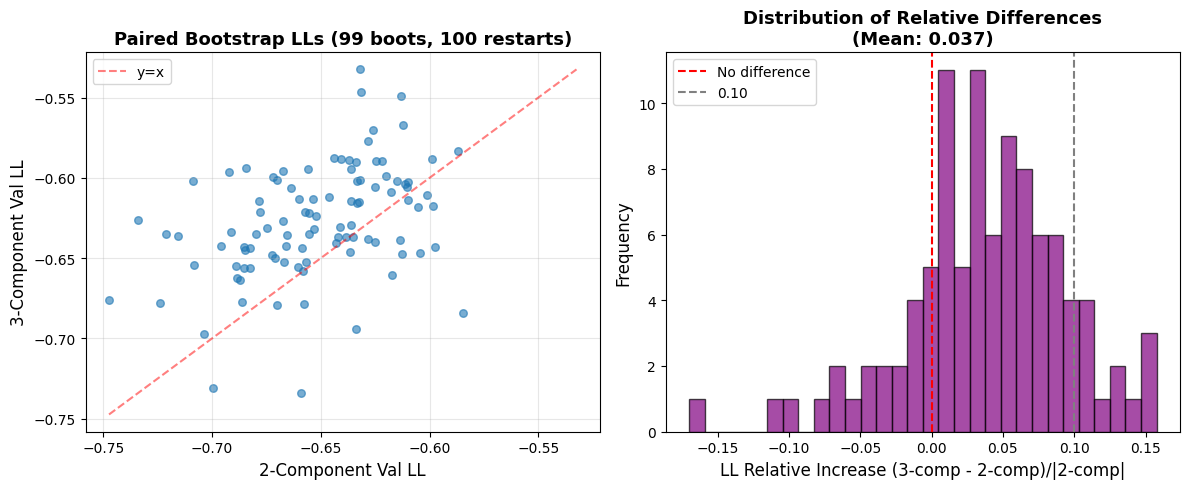

Paired t-test: t=6.579, p=0.0000
79.8% (79/99) three outperforms two
12.1% (12/99) relative diff ≥ 0.1


In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot showing paired relationship
ax1.scatter(data_2comp, data_3comp, alpha=0.6, s=30)
ax1.plot([min(data_2comp.min(), data_3comp.min()), 
          max(data_2comp.max(), data_3comp.max())], 
         [min(data_2comp.min(), data_3comp.min()), 
          max(data_2comp.max(), data_3comp.max())], 
         'r--', alpha=0.5, label='y=x')
ax1.set_xlabel('2-Component Val LL', fontsize=12)
ax1.set_ylabel('3-Component Val LL', fontsize=12)
ax1.set_title(f'Paired Bootstrap LLs ({len(data_2comp)} boots, 100 restarts)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference histogram
differences = (data_3comp - data_2comp) / abs(data_2comp)
ax2.hist(differences, bins=30, edgecolor='black', alpha=0.7, color='purple')
ax2.axvline(0, color='red', linestyle='--', label='No difference')
ax2.axvline(0.1, color='grey', linestyle='--', label='0.10')
ax2.set_xlabel('LL Relative Increase (3-comp - 2-comp)/|2-comp|', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Distribution of Relative Differences\n(Mean: {np.mean(differences):.3f})', 
              fontsize=13, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_rel(data_3comp, data_2comp)
print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.4f}")
print(f'{100*sum(differences > 0)/len(differences):.1f}% ({sum(differences > 0)}/{len(differences)}) three outperforms two')
print(f'{100*sum(differences >= 0.1)/len(differences):.1f}% ({sum(differences >= 0.1)}/{len(differences)}) relative diff ≥ 0.1')

In [28]:
from scipy.stats import wilcoxon
res = wilcoxon(differences)
float(res.statistic), float(res.pvalue)

(826.0, 8.639193894365058e-09)

/tmp/ipykernel_23135/2815062902.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, positions=[1, 2, 3.5, 4.5, 5.5],
/tmp/ipykernel_23135/2815062902.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')
/tmp/ipykernel_23135/2815062902.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, positions=[1, 2, 3.5, 4.5, 5.5],
/tmp/ipykernel_23135/2815062902.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp =

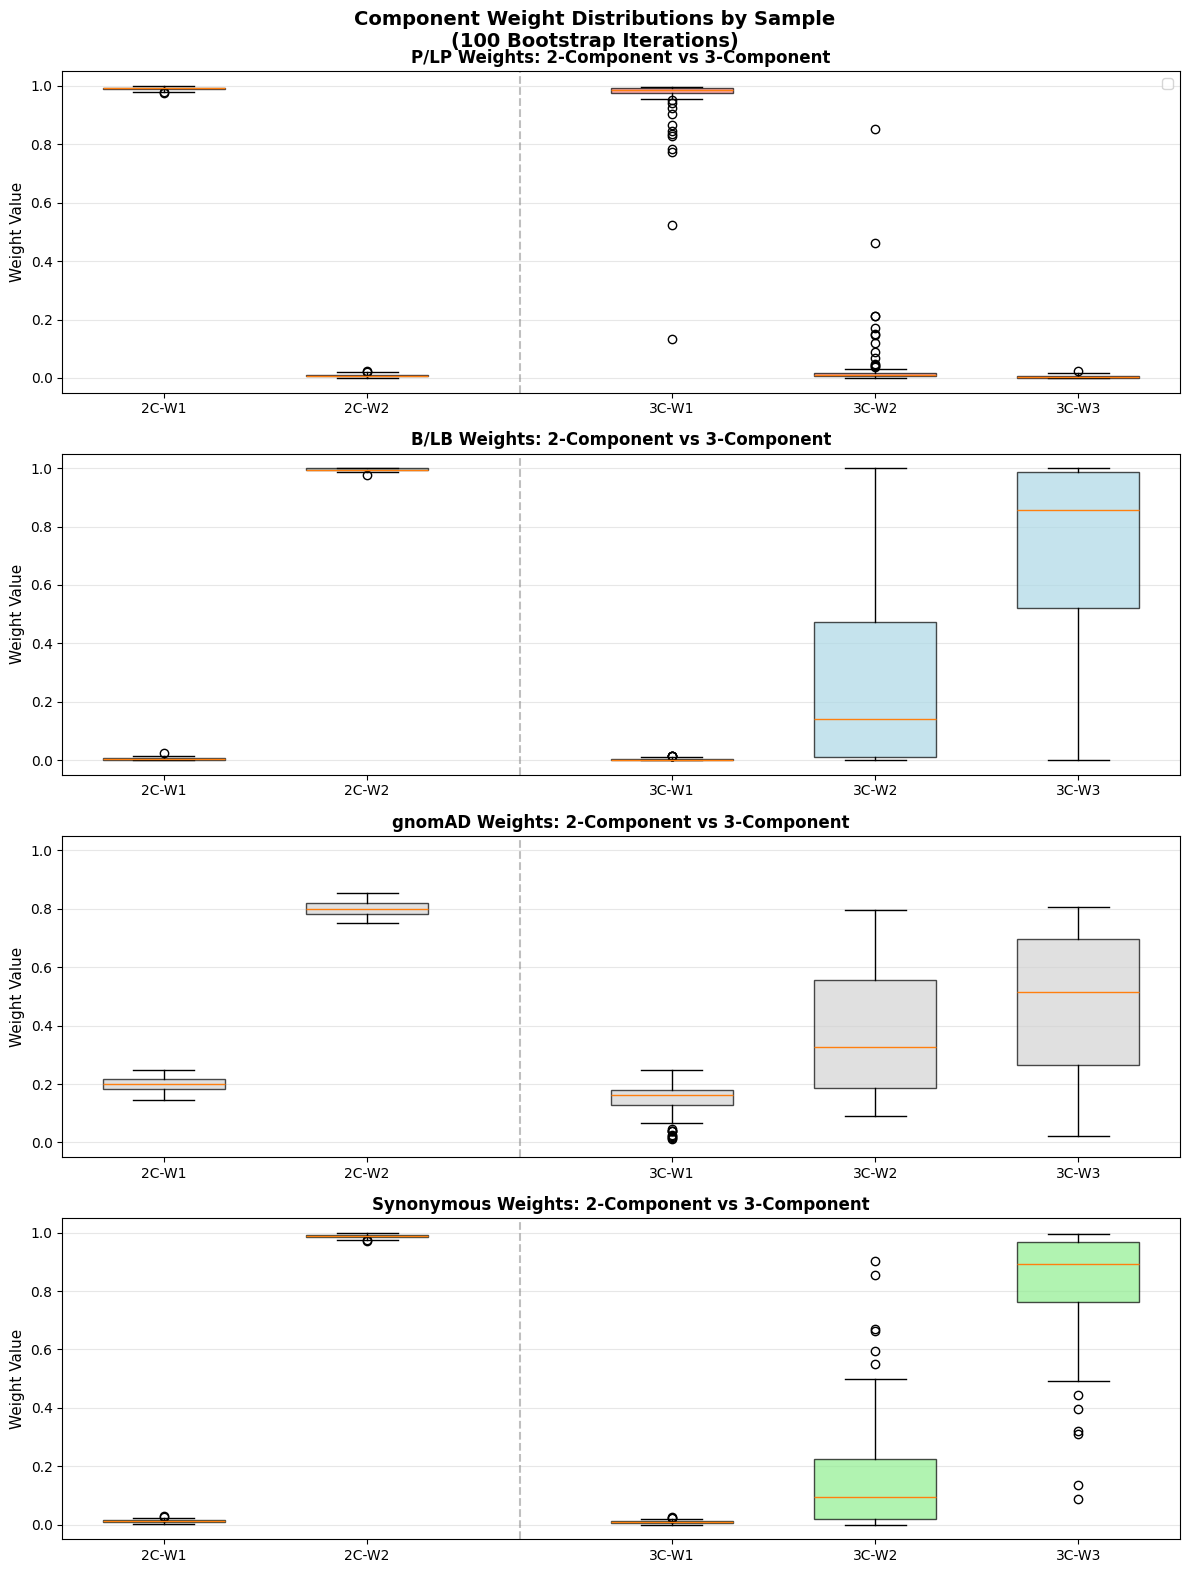

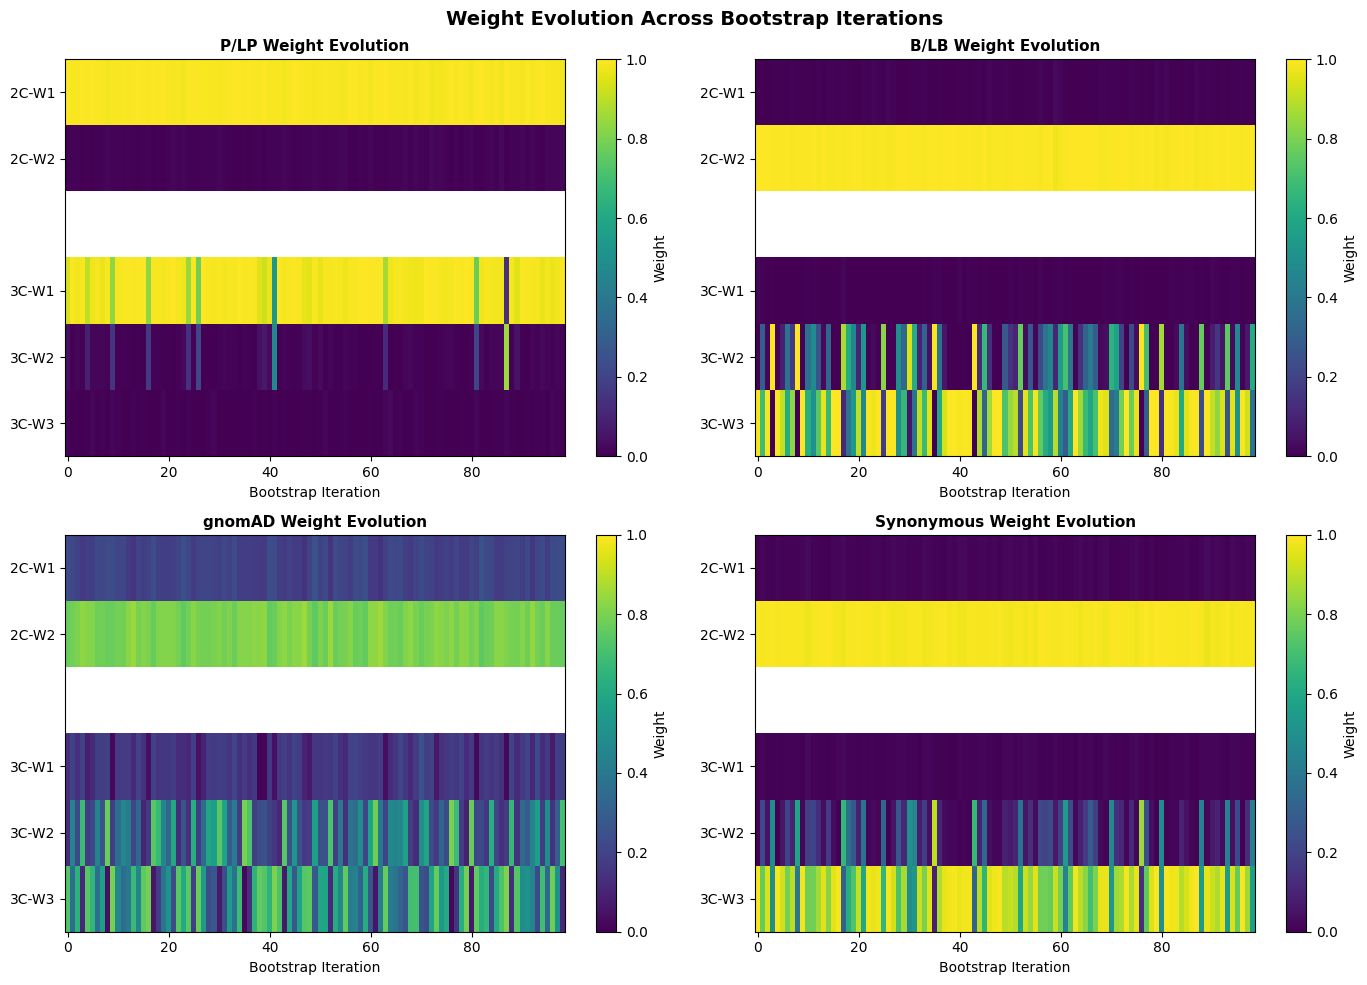


Summary Statistics by Sample:

P/LP:
  2-Component:
    Weight 1: μ=0.9914, σ=0.0052, range=[0.9773, 1.0000]
    Weight 2: μ=0.0086, σ=0.0052, range=[0.0000, 0.0227]
  3-Component:
    Weight 1: μ=0.9607, σ=0.1035, range=[0.1346, 0.9973]
    Weight 2: μ=0.0346, σ=0.1021, range=[0.0000, 0.8526]
    Weight 3: μ=0.0048, σ=0.0052, range=[0.0000, 0.0249]

B/LB:
  2-Component:
    Weight 1: μ=0.0048, σ=0.0047, range=[0.0000, 0.0237]
    Weight 2: μ=0.9952, σ=0.0047, range=[0.9763, 1.0000]
  3-Component:
    Weight 1: μ=0.0033, σ=0.0043, range=[0.0000, 0.0153]
    Weight 2: μ=0.2779, σ=0.3077, range=[0.0000, 1.0000]
    Weight 3: μ=0.7187, σ=0.3083, range=[0.0000, 1.0000]

gnomAD:
  2-Component:
    Weight 1: μ=0.1993, σ=0.0236, range=[0.1460, 0.2475]
    Weight 2: μ=0.8007, σ=0.0236, range=[0.7525, 0.8540]
  3-Component:
    Weight 1: μ=0.1489, σ=0.0502, range=[0.0111, 0.2468]
    Weight 2: μ=0.3735, σ=0.2092, range=[0.0894, 0.7977]
    Weight 3: μ=0.4777, σ=0.2377, range=[0.0228, 0.8048]



In [35]:
samples = ('P/LP','B/LB','gnomAD','Synonymous')
sample_colors = ('lightcoral','lightblue','lightgrey','lightgreen')
# Extract 2-comp and 3-comp weights
weights_2comp = weights['2-component']
weights_3comp = weights['3-component']

# Number of samples (should be same for both)
n_samples = 4

# Create figure with subplots for each sample
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 16))

for sample_idx in range(n_samples):
    ax = axes[sample_idx]
    
    # Collect weights for this sample across all bootstrap iterations
    sample_2comp_w1 = [w[sample_idx, 0] for w in weights_2comp]
    sample_2comp_w2 = [w[sample_idx, 1] for w in weights_2comp]
    
    sample_3comp_w1 = [w[sample_idx, 0] for w in weights_3comp]
    sample_3comp_w2 = [w[sample_idx, 1] for w in weights_3comp]
    sample_3comp_w3 = [w[sample_idx, 2] for w in weights_3comp]
    
    # Prepare data for boxplot
    data_to_plot = [sample_2comp_w1, sample_2comp_w2, 
                    sample_3comp_w1, sample_3comp_w2, sample_3comp_w3]
    
    # Create boxplot
    bp = ax.boxplot(data_to_plot, positions=[1, 2, 3.5, 4.5, 5.5],
                     widths=0.6, patch_artist=True,
                     labels=['2C-W1', '2C-W2', '3C-W1', '3C-W2', '3C-W3'])
    
    # Color the boxes
    colors = [sample_colors[sample_idx]] * 5
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Customize
    ax.set_ylabel('Weight Value', fontsize=11)
    ax.set_title(f'{samples[sample_idx]} Weights: 2-Component vs 3-Component', 
                 fontsize=12, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axvline(x=2.75, color='gray', linestyle='--', alpha=0.5)
    
    # Add mean values as red dots
    # means = [np.mean(d) for d in data_to_plot]
    # ax.scatter([1, 2, 3.5, 4.5, 5.5], means, color='red', s=30, zorder=3, label='Mean')
    
    # Add text with statistics
    # stats_text_2c = f'2-comp: μ₁={np.mean(sample_2comp_w1):.3f}, μ₂={np.mean(sample_2comp_w2):.3f}'
    # stats_text_3c = f'3-comp: μ₁={np.mean(sample_3comp_w1):.3f}, μ₂={np.mean(sample_3comp_w2):.3f}, μ₃={np.mean(sample_3comp_w3):.3f}'
    # ax.text(0.02, 0.95, stats_text_2c + '\n' + stats_text_3c, 
    #         transform=ax.transAxes, fontsize=9, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    if sample_idx == 0:
        ax.legend(loc='upper right')

plt.suptitle('Component Weight Distributions by Sample\n(100 Bootstrap Iterations)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Alternative: Heatmap view showing all weights
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))

for sample_idx in range(n_samples):
    ax = axes2[sample_idx // 2, sample_idx % 2]
    
    # Create matrix of weights (rows=bootstrap iterations, cols=components)
    weights_2comp_matrix = np.array([w[sample_idx, :] for w in weights_2comp])
    weights_3comp_matrix = np.array([w[sample_idx, :] for w in weights_3comp])
    
    # Combine with separator
    separator = np.full((weights_2comp_matrix.shape[0], 1), np.nan)
    combined = np.hstack([weights_2comp_matrix, separator, weights_3comp_matrix])
    
    # Plot heatmap
    im = ax.imshow(combined.T, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    
    # Labels
    ax.set_yticks([0, 1, 3, 4, 5])
    ax.set_yticklabels(['2C-W1', '2C-W2', '3C-W1', '3C-W2', '3C-W3'])
    ax.set_xlabel('Bootstrap Iteration', fontsize=10)
    ax.set_title(f'{samples[sample_idx]} Weight Evolution', fontsize=11, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Weight')

plt.suptitle('Weight Evolution Across Bootstrap Iterations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Sample:")
print("="*60)
for sample_idx in range(n_samples):
    print(f"\n{samples[sample_idx]}:")
    
    # 2-component stats
    w1_2c = [w[sample_idx, 0] for w in weights_2comp]
    w2_2c = [w[sample_idx, 1] for w in weights_2comp]
    print(f"  2-Component:")
    print(f"    Weight 1: μ={np.mean(w1_2c):.4f}, σ={np.std(w1_2c):.4f}, range=[{np.min(w1_2c):.4f}, {np.max(w1_2c):.4f}]")
    print(f"    Weight 2: μ={np.mean(w2_2c):.4f}, σ={np.std(w2_2c):.4f}, range=[{np.min(w2_2c):.4f}, {np.max(w2_2c):.4f}]")
    
    # 3-component stats
    w1_3c = [w[sample_idx, 0] for w in weights_3comp]
    w2_3c = [w[sample_idx, 1] for w in weights_3comp]
    w3_3c = [w[sample_idx, 2] for w in weights_3comp]
    print(f"  3-Component:")
    print(f"    Weight 1: μ={np.mean(w1_3c):.4f}, σ={np.std(w1_3c):.4f}, range=[{np.min(w1_3c):.4f}, {np.max(w1_3c):.4f}]")
    print(f"    Weight 2: μ={np.mean(w2_3c):.4f}, σ={np.std(w2_3c):.4f}, range=[{np.min(w2_3c):.4f}, {np.max(w2_3c):.4f}]")
    print(f"    Weight 3: μ={np.mean(w3_3c):.4f}, σ={np.std(w3_3c):.4f}, range=[{np.min(w3_3c):.4f}, {np.max(w3_3c):.4f}]")

In [21]:
n_non_violating_fits_without_constraint = [0,0]
n_violating_fits_without_constraint = [0,0]
for dataset_f in glob.glob("/data/ross/assay_calibration/scoresets/*.json"):
    dataset_name = dataset_f.split('/')[-1][:-5]
    for i,component_range in enumerate(["2-component", "3-component"]):
        for monotonicity_constraint in ["constraint", "no constraint"]:
            if (component_range,monotonicity_constraint) not in all_results[dataset_name]:
                continue
            params = all_results[dataset_name][(component_range,monotonicity_constraint)]['component_params']
            xlims = all_results[dataset_name][(component_range,monotonicity_constraint)]['xlims']
            fit_violates_constraint = constraints.multicomponent_density_constraint_violated(params, xlims)
            if monotonicity_constraint == "no constraint" and fit_violates_constraint:
                n_violating_fits_without_constraint[i] += 1
            elif monotonicity_constraint == "no constraint":
                n_non_violating_fits_without_constraint[i] += 1

for i,component_range in enumerate(["2-component", "3-component"]):
    print(f'{component_range}: {100*n_non_violating_fits_without_constraint[i]/(n_non_violating_fits_without_constraint[i]+n_violating_fits_without_constraint[i]):.1f}% ({n_non_violating_fits_without_constraint[i]}/{n_non_violating_fits_without_constraint[i]+n_violating_fits_without_constraint[i]}) did not violate the constraint.')

                

2-component: 44.4% (36/81) did not violate the constraint.
3-component: 12.8% (10/78) did not violate the constraint.


In [12]:
temp = 0

temp

166

In [10]:
ds = Scoreset.from_json('/data/ross/assay_calibration/scoresets/CALM1_CALM2_CALM3_Weile_2017.json')
ds.scores[ds.sample_assignments[:,2]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# 'HMBS_van_Loggerenberg_2023_combined', 'TP53_Fortuno_2021_Kato_meta' truth value of arr
# 'KCNH2_Jiang_2022', 'KCNH2_O_Neill_2024_surface_expression' ll decreased consistently & xlims



In [8]:
constraints.multicomponent_density_constraint_violated(best_fit['component_params'],
                                                       score_range[[0,-1]])

True

In [9]:
best_fit.keys()

dict_keys(['component_params', 'weights', 'likelihoods', 'history', 'kmeans'])

In [10]:
best_fit['component_params']

[(-8.553172420104763, 0.7949678509378952, 0.24375170761527565),
 (-1.4489019235176928, 0.9296749533938731, 0.04216918377139136),
 (-7.860341896888932e-05, 1.003620376681616, 0.020770124957920067)]

In [11]:
scores.min(),scores.max()

(np.float64(-0.483185729440366), np.float64(1.36169269063829))

In [12]:
# Iteration 9618: Likelihood DECREASED by 1.96e-06 (relative: 3.51e-06) - algorithmic issue